In [5]:
import re, string 
import pandas as pd
import numpy as np
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from transformers import BertModel, BertConfig, BertTokenizer, PreTrainedTokenizer
import csv

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower().strip()
    text = re.sub(r'\[*\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    #removes unicodes and other miscelaneous symbols left in text so model does not learn them
    text = re.sub('^\\\\u[\d\D]{4}|-|σ|→|\\\\xad', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
    return 


In [7]:
def tokenizer(text):
    #BERT tokenizer is used to tokenize text
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer.tokenize(str(text), add_special_tokens=True)
    return tokens

In [8]:
nlp = spacy.load('en_core_web_sm')

def lemmatizer(text):
    #Sometimes after cleaning the text all words in a row are removed. The if statement let's you know when this occurs
    if text == None:
        print("Excuse me but there is an unexpected None value from cleaning the text!")
        return ""
    sent = []
    tokens = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [9]:
def feed2vec(filepath, tokenize=None):
    '''Feed2vec prepares the text corpus for word2vec to train on. It first takes a JSON filepath and puts it into a pandas data frame
       Then it cleans the text using the clean_text function. Afterwards, all of the rows with None values are removed.
       The default is to not use the tokenie function. If one sets tokenize = True, then the tokenizer function will use BERT to tokenize 
       the text corpus one sentence at a time. All tokens are appended to a tokens list. '''
    global sentences, tokens
    
    print("filepath is ", str(filepath))
    #Creates a pandas dataframe for the text data from a json file
    if ".json" in str(filepath):
        df = pd.read_json(filepath)
    
    else:   
    #FIXING THE READ JSON THING HERE W LOADING IT THEN WRITING? BC ABOVE IS GIVING ME A VALUE ERROR THAT'S HARD TO FIX
        with open(filepath, "r") as read_file:
            dataInit = json.load(read_file)
        df = pd.DataFrame(data = dataInit)
    
    #print("data type loaded from json is ", type(dataInit))
    print(df.head(n = 10))
    
    #Adds the column label text
    df.columns = ['text']
    
    #Text clean function is applied to the pandas dataframe
    df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))
    
    #filters out all the None values in the cleaned dataset
    #loc combines the operations in brackets into one single operation to avoid chaining indexes operations together
    #copy explicitly tells pandas to make copy when creating master_of_none
    #this is so later on only the copy is modified and there is no confusion between the copy and the original
    master_of_none = df_clean.loc[df_clean.text.notnull()].copy()
    
    if tokenize == None:   #no tokenizing at all
        tokens = None
        #Lemmatizer function is applied to cleaned text with the none values removed
        master_of_none["text_lemmatized"] =  master_of_none.apply(lambda x: lemmatizer(x['text']), axis=1)
        master_of_none['text_lemmatize_clean'] = master_of_none['text_lemmatized'].str.replace('-PRON-', '')
        vocab = master_of_none['text_lemmatize_clean']
        
        sentences = [row.split() for row in vocab]
        word_freq = defaultdict(int)
        for sent in sentences:
            for i in sent:
                word_freq[i] += 1
        len(word_freq)
        
    else:   #returns sentences as tokens using the BERT tokenizer function
        tokens = []
        sentences = sent_tokenize(str(master_of_none["text"]))
        word_freq = defaultdict(int)
        for sent in sentences:
            tokens.append(tokenizer(sent))
            for i in sent:
                word_freq[i] += 1
        len(word_freq)
    

    return tokens 

In [10]:
def w2v_train(w2vmodel, last_model = False, min_count = 2, window = 5, size = 500):   
    '''This function is designed to train word2vec from gensim on your text corpus that you prepared in the feed2vec function. Default variables for w2v to use are already given.
    You can specifiy them if you want. Both w2vmodel and last_model should be saved in model_name_here.model format. The variable w2vmodel is the name of the new model that you want to     save it as. If you are adding a text corpus to a previous model, then the name of the previous model should be listed in the last_model variable. '''
    global sentences, tokens #makes the variables visible to other functions instead of local to that function
    if tokens is not None:
        words = tokens
    else:
        words = sentences
    
    if last_model == True:
        #Previously updated model is loaded
        w2v_model = Word2Vec.load(last_model)  
        
        #model vocabulary is updated
        w2v_model.build_vocab(words, update=True)
        
    elif last_model == False:
        # min_count: minimum number of occurrences of a word in the corpus to be included in the model.
        # window: the maximum distance between the current and predicted word within a sentence.
        # size: the dimensionality of the feature vectors
        # workers: the number of cores your computer has
        w2v_model = Word2Vec(min_count = min_count,
                             window = window,
                             size = size)                    
        #the new model's vocabulary is built 
        w2v_model.build_vocab(words)
        
    # trains the built vocab on the w2v model
    
    try:
        t = time()
        w2v_model.train(words, total_examples=w2v_model.corpus_count, epochs= 30, report_delay = 1)       #w2v_model.epochs
        
    except RuntimeError:
        print("Vocab was not built. Check your w2v parameters and try again!")
    #Sometimes there is a RuntimeError stating that the vocab needs to be built first.
    #This problem occurs when the Word2Vec parameters end up excluding all words in the text corpus.
    #The default variables may not work in some cases, so you may have to manually specify.
    
    #This tells you how long it took to train the model
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2))) #added here
    
   #Trained word vectors are stored in a KeyedVectors instance
    #This object is smaller and faster to load.Thereby making it easier to share the vectors here. 
    fname = get_tmpfile("vectors.kv")
    word_vectors = []
    word_vectors = w2v_model.wv
    word_vectors.save(fname)
    word_vectors = KeyedVectors.load(fname, mmap='r')
    
    all_vectors = []
    
    #returns the number of words in the vocab and the number of words in the corpus
    print("corpus count is ", w2v_model.corpus_count)
    print("epochs is ", w2v_model.epochs)
    
    #Puts all vectors in model in the all vectors list
    for word in w2v_model.wv.vocab:
        
        all_vectors.append(w2v_model.wv[word])  #to here

    w2v_model.save(w2vmodel)
    print("keyed vectors ", word_vectors)
    print("all_vectors(done via vocab) ", all_vectors)
    #return print("Training complete!")
    
    return word_vectors                   
    

In [11]:

first_word = ['alcohol', 'ketone', 'alkene', 'carbon', 'proton', 'polymer', 'acid', 'oxidize', 'anion', 'electrophile', 'polar', 'positive', 'mechanism', 'resonance', 'synthesis', 'isomer', 'heat', 'aromatic', ]
second_word = ['hydroxyl', 'carbonyl', 'alkyne', 'nitrogen', 'hydrogen', 'chain', 'base', 'reduce', 'cation', 'nucleophile', 'nonpolar', 'negative', 'atom', 'solvent', 'electron', 'reaction', 'bond', 'equilibrium']
my_headers = ['model_name', 'alcohol + hydroxyl', 'ketone + carbonyl', 'alkene + alkyyne', 'carbon + nitrogen', 'proton + hydrogen', 'polymer + chain', 'acid + base', 'oxidize + reduce', 'anion + cation', 'electrophile + nucleophile', 'polar + nonpolar', 'positive + negative', 'mechanism + atom', 'resonance + solvent', 'synthesis + electron', 'isomer + reaction', 'heat + bond', 'aromatic + equilibrium', 'Top 10 Carbon']
t10 = 'carbon'

def cosine_sim(w2vmodel, first_word, second_word, t10):
    '''The variable w2vmodel is the model that you want to get the cosine similarity values from. There are defaults values for first_word, second_word, and t10 in the file. You can
    specify your own values for each variable too. Just make sure the words are in ''. 
    
    First, the name of the model is added to the w2v_data list, so there is a model associated with the cosine sim data. Then 2 lists called first_word and second_word are zipped 
    together to form word pairs.For each word pair, the cos sim is calculated, and the value is added to the w2v_data list. This is also done for the top10 most similar words to the t10 
    value. Note the default t10 is carbon.'''
    global w2v_data
    model_name = w2vmodel
    
    w2v_model = Word2Vec.load(w2vmodel)
    
    w2v_data = []
    
    w2v_data.append(model_name)
    
    for word1, word2 in zip(first_word, second_word):
        try:
        #synonym, antonym, or neutral pairs
            cos_sim = w2v_model.wv.similarity(word1, word2)
            w2v_data.append(cos_sim)
        except KeyError:
            cos_sim = 0 
            w2v_data.append(cos_sim)
            print(f"{word1} or {word2} was not in the vocabulary")
   
    try:
        top10 = w2v_model.wv.most_similar(positive=[t10])
        w2v_data.append(top10)
    except KeyError:
        top10 = 0
        print(t10, "is not in the vocabulary")
    
    
    return print("Data collection and saving complete!")

In [12]:
def data_saver(excel_file, my_headers, new_file = None):
    '''The data_saver function takes the w2v_data from cosine_sim function and adds them to a CSV file. The variable excel_file is the name of the CSV file that you want to save
    the data to. The variable my_headers is a list of the csv headers that correspond to each word pair in the cosine_sim function. One needs to specify new_file if you are not adding 
    to a previously made CSV file. '''
    try:
        if new_file is not None:
            with open(excel_file, 'w',  newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(my_headers)
                csvwriter.writerow(w2v_data)
        else:
            with open(excel_file, 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(w2v_data)
    except PermissionError:
        print("Excel file is most likely open. Close it before running program")
    return print("Data saved!!!")

In [25]:
def tsne_grapher(w2vmodel, word):
    "Create TSNE model and plot it"
    labels = [word]
    
    #Create an empty array with numpy
    arr = np.empty((0,400), dtype='f')
    
    model = Word2Vec.load(w2vmodel)
    vocab = model.wv.most_similar(word)
    
    # add the vector for each of the closest words to the array
    #arr = np.append(arr, np.array([model[word_embed]]), axis=0)
    for word_embed in vocab:
        vectors = model[word_embed[0]]
        labels.append(word_embed[0])
        arr = np.append(arr, np.array([vectors]), axis=0)
        
        
    
    tsne_model = TSNE(n_components=2, perplexity=90, init='pca', early_exaggeration=12, learning_rate=100, n_iter=1000) 
    np.set_printoptions(suppress=True)
    new_values = tsne_model.fit_transform(arr)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.grid(True)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.tick_params(length=20)
    plt.xlabel("cos sim", fontsize=24)
    plt.ylabel("cos sim", fontsize=24)
    plt.title("Test plot", fontsize=36)
    plt.show()
    return

C:\Users\louis\anaconda3\envs\Chem_NLP\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


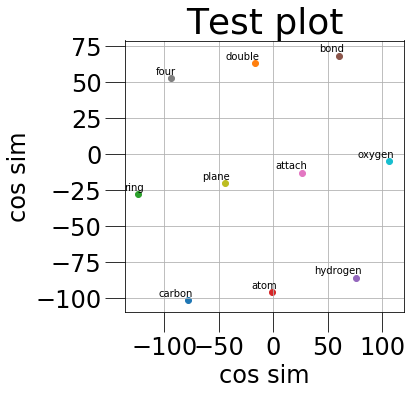

In [26]:
word_pairs = zip(first_word, second_word)
tsne_grapher('No_tokenize/trial_1.model', 'carbon')

In [80]:
file1 = 'ChemLibre_JSONS/Basic_Principles_of_Organic_Chemistry_Roberts_and_Caserio.json'
file2 = 'ChemLibre_JSONS/Bruice_Map.json'
file3 = 'ChemLibre_JSONS/Catalytic_Asymmetric_Synthesis_Punniyamurthy.json'
file4 = 'ChemLibre_JSONS/Environmental_Chemistry.json'
file5 = 'ChemLibre_JSONS/How_to_be_a_Successful_Organic_Chemist_Sandtorv.json'
file6 = 'ChemLibre_JSONS/Logic_of_Organic_Synthesis_Rao.json'
file7 = 'ChemLibre_JSONS/Organic_Chemistry_A _Carbonyl_Early_Approach_McMichael.json'
file8 = 'ChemLibre_JSONS/Organic_Chemistry_Lab_Techniques_Nichols.json'
file9 = 'ChemLibre_JSONS/Organic_Chemistry_with_a_Biological_Emphasis_Soderberg.json'
file10 = 'ChemLibre_JSONS/Polymer_Chemistry.json'
file11 = 'ChemLibre_JSONS/Radical_Reactions_of_Carbohydrates_Binkley.json'
file12 = 'ChemLibre_JSONS/Schaller_Polymer.json'
file13 = 'ChemLibre_JSONS/Supplemental_Modules.json'
file14 = 'ChemLibre_JSONS/Wade_Map.json'
file15 = 'Springer_PDF/Brewing_Science_A_Multidisciplinary_Approach_by_Mosher_and_Trantham.json'
file16 = 'Springer_PDF/Advanced_Organic_Chemistry_Part_A_Structure_and_Mechanisms_by_Carey_and_Sundberg.json'
file17 = 'Springer_PDF/Advanced_Organic_Chemistry_Part_B_Reactions_and_Synthesis_by_Carey_and_Sundberg.json'
file18 = 'Springer_PDF/Principles_of_Polymer_Chemistry_by_Ravve.json'
file19 = 'Springer_PDF/Polymer_Synthesis_Theory_and_Practice_by_Braun_Cherdron_Rehahn_Ritter_and_Voit.json'
file20 = 'Springer_PDF/Polymer_Chemistry_by_Koltzsenburg_Maskos_and_Nuyken.json'

In [81]:
model1 = 'robers_and_caserio.model'
model2 = 'bruice.model'
model3 = 'punniyamurthy.model'
model4 = 'environmental.model'
model5 = 'sandtorv.model'
model6 = 'rao.model'
model7 = 'mcmichael.model'
model8 = 'nichols.model'
model9 = 'soderberg.model'
model10 = 'polymer.model'
model11 = 'binkley.model'
model12 = 'schaller.model'
model13 = 'supplemental.model'
model14 = 'wade.model'
model15 = 'mosher_and_trantham.model'
model16 = 'a_carey_and_sundberg.model'
model17 = 'b_carey_and_sundberg.model'
model18 = 'ravve.model'
model19 = 'braun_chedron_rehahn_ritter_and_voit.model'
model20 = 'koltzsenburg_maskos_and_nuyken.model'

In [15]:
import matplotlib
matplotlib.matplotlib_fname()

'C:\\Users\\louis\\anaconda3\\envs\\Chem_NLP\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'

In [43]:
w2vmodel = 'No_tokenize/trial_1.model'
model = Word2Vec.load(w2vmodel)
vocab = model.wv.most_similar(positive=['carbon'], topn=30)

In [52]:
print(vocab)

[('double', 0.9225300550460815), ('ring', 0.8929932117462158), ('atom', 0.8779053688049316), ('hydrogen', 0.8733813166618347), ('bond', 0.8710341453552246), ('attach', 0.8688429594039917), ('four', 0.8592382669448853), ('plane', 0.8579606413841248), ('oxygen', 0.8523372411727905), ('call', 0.842073917388916), ('two', 0.8306570053100586), ('single', 0.8182722330093384), ('length', 0.8124610781669617), ('three', 0.8109778165817261), ('together', 0.8041499853134155), ('valence', 0.7954367399215698), ('configuration', 0.7909128665924072), ('position', 0.7892582416534424), ('chain', 0.7883191108703613), ('c−c', 0.7854520082473755), ('six', 0.7846163511276245), ('carboncarbon', 0.7801902294158936), ('different', 0.7794722318649292), ('arrangement', 0.7772564888000488), ('planar', 0.7719137072563171), ('substituent', 0.7686742544174194), ('thus', 0.7684073448181152), ('one', 0.7649726867675781), ('conformation', 0.7608965039253235), ('repulsion', 0.7573059797286987)]


In [48]:
vector = model.wv['carbon']

In [49]:
print(vector)

[-0.05513263  0.02142916  0.06324746 -0.00128333  0.18580635 -0.03683378
 -0.14749481  0.04378621  0.13856219 -0.06318045 -0.19241787  0.11368435
 -0.08240587  0.06168922  0.03561117  0.05187724  0.22782223  0.1485802
 -0.08352183 -0.02940531  0.00554641  0.24744642 -0.06432577  0.07394985
 -0.00066584  0.08049276 -0.00146983  0.22026013  0.07815512  0.19338112
  0.00160768 -0.0303425   0.33908847  0.07927419 -0.20589495  0.02841559
  0.0706097   0.2723756  -0.20683523  0.14543173 -0.09676453  0.10653083
  0.1177285  -0.02788298 -0.32050097  0.18366995 -0.13742171  0.06471886
  0.05562606 -0.20019759 -0.28722993  0.27843028 -0.27611166  0.33173323
  0.09052377 -0.06918064  0.10289845 -0.04265032 -0.13524818 -0.03451826
  0.01705047 -0.1424571  -0.0359433  -0.2267961   0.0452297   0.08815791
 -0.04819756  0.17934105 -0.01994951  0.071286    0.04976322  0.04123519
 -0.16216187 -0.2812378   0.19238414  0.16436215  0.06475949 -0.19317304
  0.30191427  0.0539673   0.09974545 -0.21940993 -0.